## Modelo LightGBM Gradient Boosting: 

In [1]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Leemos el fichero con provincias
path_file = 'C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/modeloST_CTO_provincia.csv'

df = pd.read_csv(path_file, sep=';')
print(df.head(10))
# Transformamos la variable 'Fecha de solicitud'a tipo timastamp
df['Fecha de solicitud']=pd.to_datetime(df['Fecha de solicitud'], errors='coerce', format='%Y-%m-%d')
print(f'Tipo de datos del datrame:\n{df.dtypes}Fechas de solicitud:\n{df['Fecha de solicitud'].head(5)}')

  Fecha de solicitud    Provincia  Número de ampliaciones
0         2019-01-18     ALBACETE                       1
1         2019-01-18    CASTELLON                      10
2         2019-01-18  CIUDAD REAL                      24
3         2019-01-18       CUENCA                       1
4         2019-01-18  GUADALAJARA                       1
5         2019-01-18       LLEIDA                       7
6         2019-01-18       MADRID                      17
7         2019-01-18    SALAMANCA                       4
8         2019-01-18       TOLEDO                      25
9         2019-01-18     VALENCIA                      14
Tipo de datos del datrame:
Fecha de solicitud        datetime64[ns]
Provincia                         object
Número de ampliaciones             int64
dtype: objectFechas de solicitud:
0   2019-01-18
1   2019-01-18
2   2019-01-18
3   2019-01-18
4   2019-01-18
Name: Fecha de solicitud, dtype: datetime64[ns]


In [3]:
# Incluimos columnas de año, número de semana y un identificador único año-semana
df['Año'] = df['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df['Semana'] = df['Fecha de solicitud'].dt.isocalendar().week.astype(int)
df['Semana_Año'] = df['Año'].astype(str) + '-W' + df['Semana'].astype(str).str.zfill(2) 
len(df), df.head(5), df.tail(5)


(4914,
   Fecha de solicitud    Provincia  Número de ampliaciones   Año  Semana  \
 0         2019-01-18     ALBACETE                       1  2019       3   
 1         2019-01-18    CASTELLON                      10  2019       3   
 2         2019-01-18  CIUDAD REAL                      24  2019       3   
 3         2019-01-18       CUENCA                       1  2019       3   
 4         2019-01-18  GUADALAJARA                       1  2019       3   
 
   Semana_Año  
 0   2019-W03  
 1   2019-W03  
 2   2019-W03  
 3   2019-W03  
 4   2019-W03  ,
      Fecha de solicitud    Provincia  Número de ampliaciones   Año  Semana  \
 4909         2025-09-30     ASTURIAS                       1  2025      40   
 4910         2025-09-30  CIUDAD REAL                       1  2025      40   
 4911         2025-09-30       GIRONA                       1  2025      40   
 4912         2025-09-30      GRANADA                       2  2025      40   
 4913         2025-09-30         JAEN      

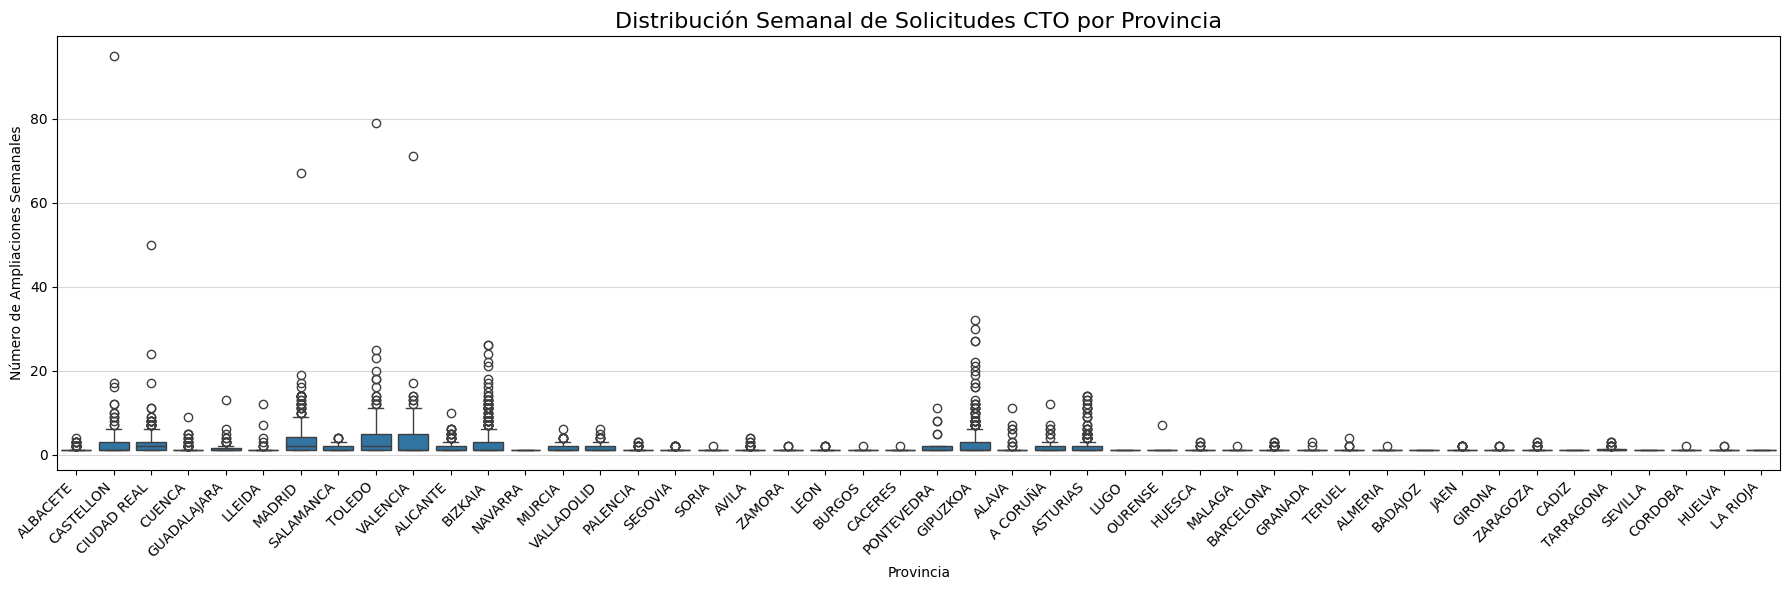

In [4]:
# Exploramos para ver si tenemos outliers con el boxplot
plt.figure(figsize=(18, 6))
sns.boxplot(x='Provincia', y='Número de ampliaciones', data=df)
plt.title('Distribución Semanal de Solicitudes CTO por Provincia', fontsize=16)
plt.xlabel('Provincia')
plt.ylabel('Número de Ampliaciones Semanales')
plt.xticks(rotation=45, ha='right') # Rota las etiquetas de las provincias para mejor lectura
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [5]:
# Eliminar los outliers
df_semana = (
    df.groupby('Semana_Año')['Número de ampliaciones'].sum().sort_values(ascending=False).head(10)
)
print(df_semana)


Semana_Año
2019-W07    417
2019-W03    104
2019-W17    103
2023-W07    100
2023-W09     99
2023-W08     98
2023-W10     96
2023-W06     86
2023-W05     80
2023-W25     79
Name: Número de ampliaciones, dtype: int64


In [6]:
print(df.head(5))
df_modelo = df.drop(df[(df['Año']==2019)&(df['Semana']==7)].index)
print(df_modelo.head(5))

  Fecha de solicitud    Provincia  Número de ampliaciones   Año  Semana  \
0         2019-01-18     ALBACETE                       1  2019       3   
1         2019-01-18    CASTELLON                      10  2019       3   
2         2019-01-18  CIUDAD REAL                      24  2019       3   
3         2019-01-18       CUENCA                       1  2019       3   
4         2019-01-18  GUADALAJARA                       1  2019       3   

  Semana_Año  
0   2019-W03  
1   2019-W03  
2   2019-W03  
3   2019-W03  
4   2019-W03  
  Fecha de solicitud    Provincia  Número de ampliaciones   Año  Semana  \
0         2019-01-18     ALBACETE                       1  2019       3   
1         2019-01-18    CASTELLON                      10  2019       3   
2         2019-01-18  CIUDAD REAL                      24  2019       3   
3         2019-01-18       CUENCA                       1  2019       3   
4         2019-01-18  GUADALAJARA                       1  2019       3   

  Semana

### df -> df con el outlier df_sin_outlier -> df sin outlier, haremos la predicción con los df.

### Transformamos la variable categórica en variables numéricas.

In [7]:
# Creamos un id numérico para cada provincia
df_modelo['Provincia_ID'] = df_modelo['Provincia'].astype('category').cat.codes
print(df_modelo.head(5))
print(df_modelo['Provincia_ID'])
df_modelo = df_modelo.loc[:, ~df_modelo.columns.duplicated()]
print(df_modelo.head(5))

  Fecha de solicitud    Provincia  Número de ampliaciones   Año  Semana  \
0         2019-01-18     ALBACETE                       1  2019       3   
1         2019-01-18    CASTELLON                      10  2019       3   
2         2019-01-18  CIUDAD REAL                      24  2019       3   
3         2019-01-18       CUENCA                       1  2019       3   
4         2019-01-18  GUADALAJARA                       1  2019       3   

  Semana_Año  Provincia_ID  
0   2019-W03             2  
1   2019-W03            13  
2   2019-W03            14  
3   2019-W03            16  
4   2019-W03            20  
0        2
1       13
2       14
3       16
4       20
        ..
4909     5
4910    14
4911    18
4912    19
4913    23
Name: Provincia_ID, Length: 4899, dtype: int8
  Fecha de solicitud    Provincia  Número de ampliaciones   Año  Semana  \
0         2019-01-18     ALBACETE                       1  2019       3   
1         2019-01-18    CASTELLON                      10 

### Aplicamos la técnica del one-hot encoding para evitar inferir orden en la asignaciónd de los id para las provincias y afecte al entrenamiento del modelo.

In [8]:
# Utilizamos la técnica de one-hot encoding para convertir la variable categórica 'Provincia' en variables dummy y evitar que se pueda interpretar un orden entre ellas
df_provincias_encoded  = pd.get_dummies(df_modelo, columns=['Provincia'], prefix='Provincia')
df_modelo = pd.concat([df_modelo, df_provincias_encoded], axis=1)
df_modelo.head(5)

,Fecha de solicitud,Provincia,Número de ampliaciones,Año,Semana,Semana_Año,Provincia_ID,Fecha de solicitud,Número de ampliaciones,Año,...,Provincia_SEGOVIA,Provincia_SEVILLA,Provincia_SORIA,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA
0,2019-01-18,ALBACETE,1,2019,3,2019-W03,2,2019-01-18,1,2019,...,False,False,False,False,False,False,False,False,False,False
1,2019-01-18,CASTELLON,10,2019,3,2019-W03,13,2019-01-18,10,2019,...,False,False,False,False,False,False,False,False,False,False
2,2019-01-18,CIUDAD REAL,24,2019,3,2019-W03,14,2019-01-18,24,2019,...,False,False,False,False,False,False,False,False,False,False
3,2019-01-18,CUENCA,1,2019,3,2019-W03,16,2019-01-18,1,2019,...,False,False,False,False,False,False,False,False,False,False
4,2019-01-18,GUADALAJARA,1,2019,3,2019-W03,20,2019-01-18,1,2019,...,False,False,False,False,False,False,False,False,False,False


### Como necesitamos solo variables numéricas para los modelos de machine learning, eliminamos la variable 'Provincia'.

In [9]:
# Eliminamos la columna de texto original 'Provincia'
df_modelo = df_modelo.drop('Provincia', axis=1)
print(df_modelo.dtypes)

Fecha de solicitud        datetime64[ns]
Número de ampliaciones             int64
Año                                int64
Semana                             int64
Semana_Año                        object
Provincia_ID                        int8
Fecha de solicitud        datetime64[ns]
Número de ampliaciones             int64
Año                                int64
Semana                             int64
Semana_Año                        object
Provincia_ID                        int8
Provincia_A CORUÑA                  bool
Provincia_ALAVA                     bool
Provincia_ALBACETE                  bool
Provincia_ALICANTE                  bool
Provincia_ALMERIA                   bool
Provincia_ASTURIAS                  bool
Provincia_AVILA                     bool
Provincia_BADAJOZ                   bool
Provincia_BARCELONA                 bool
Provincia_BIZKAIA                   bool
Provincia_BURGOS                    bool
Provincia_CACERES                   bool
Provincia_CADIZ 

### Creamos las variables de memoria temporal

In [10]:
# Creamos las variables de memoria temporal
TARGET = 'Número de ampliaciones'
lags_a_crear = [1, 4, 52] 
df_modelo = df_modelo.loc[:, ~df_modelo.columns.duplicated()]
for lag in lags_a_crear:
    nueva_columna = f'{TARGET}_L{lag}'
    
    # El groupby() ahora debería funcionar sin problemas
    df_modelo[nueva_columna] = (
        df_modelo
        .groupby('Provincia_ID')[TARGET]
        .shift(lag)
    )
print(df_modelo.tail())

     Fecha de solicitud  Número de ampliaciones   Año  Semana Semana_Año  \
4909         2025-09-30                       1  2025      40   2025-W40   
4910         2025-09-30                       1  2025      40   2025-W40   
4911         2025-09-30                       1  2025      40   2025-W40   
4912         2025-09-30                       2  2025      40   2025-W40   
4913         2025-09-30                       2  2025      40   2025-W40   

      Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
4909             5               False            False               False   
4910            14               False            False               False   
4911            18               False            False               False   
4912            19               False            False               False   
4913            23               False            False               False   

      Provincia_ALICANTE  ...  Provincia_TARRAGONA  Provincia_TERUEL

In [11]:
# Eliminamos las filas incompletas
df_modelo = df_modelo.dropna(subset=[f'{TARGET}_L{lags_a_crear[-1]}'])

print("\n--- ¡Paso 3 Exitoso! Estructura Final con Lags ---")
print(df_modelo.head())


--- ¡Paso 3 Exitoso! Estructura Final con Lags ---
    Fecha de solicitud  Número de ampliaciones   Año  Semana Semana_Año  \
423         2019-12-13                       4  2019      50   2019-W50   
426         2019-12-18                       1  2019      51   2019-W51   
428         2019-12-19                       2  2019      51   2019-W51   
430         2019-12-23                       2  2019      52   2019-W52   
433         2020-01-09                       1  2020       2   2020-W02   

     Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
423            41               False            False               False   
426            41               False            False               False   
428            41               False            False               False   
430            28               False            False               False   
433            28               False            False               False   

     Provincia_ALICANTE  ...

In [12]:
# Importamos las librerías del modelo
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import pandas as pd

In [13]:
# Generamos el conjunto de entrenamiento y test
fecha_corte = pd.to_datetime('2024-06-30')

# Conjunto de Entrenamiento (Train): Datos hasta la W39 2025
df_train = df_modelo[df_modelo['Fecha de solicitud'] <= fecha_corte].copy()

In [14]:
# Necesitamos generar las features, las varibles predictoras y la objetivo al ser un modelo de aprendizaje supervisado
excluir_cols = ['Fecha de solicitud', 'Semana_Año', TARGET] # Excluimos el objetivo y las etiquetas
# El resto de columnas (Lags, Año, Semana_del_Año, Provincia_ID, Provincia_dummies) son las features.
features = [col for col in df_train.columns if col not in excluir_cols]

In [15]:
# Preparamos el X_train (entrada al modelo) e y_Train (la eqiruta de salida)
X_train = df_train[features]
y_train = df_train[TARGET]
print(f'Cabecera del X train:\n{X_train.head(5)}\nCabecera del Y train:\n{y_train.head(5)}')

Cabecera del X train:
      Año  Semana  Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  \
423  2019      50            41               False            False   
426  2019      51            41               False            False   
428  2019      51            41               False            False   
430  2019      52            28               False            False   
433  2020       2            28               False            False   

     Provincia_ALBACETE  Provincia_ALICANTE  Provincia_ALMERIA  \
423               False               False              False   
426               False               False              False   
428               False               False              False   
430               False               False              False   
433               False               False              False   

     Provincia_ASTURIAS  Provincia_AVILA  ...  Provincia_TARRAGONA  \
423               False            False  ...                False   
426     

In [16]:
print("--- División de Datos de Entrenamiento (X_train y y_train) ---")
print(f"Fecha de fin de entrenamiento: {df_train['Fecha de solicitud'].max().strftime('%Y-%m-%d')}")
print(f"Número de filas de entrenamiento (Train): {len(df_train)}")
print(f"Número de variables predictoras (Features): {len(features)}")

--- División de Datos de Entrenamiento (X_train y y_train) ---
Fecha de fin de entrenamiento: 2024-06-28
Número de filas de entrenamiento (Train): 2076
Número de variables predictoras (Features): 52


### Creamos el DF de predicción

In [17]:
# 1. Definir el horizonte temporal futuro (W40 a W52 de 2025)
fechas_futuras = pd.date_range(start='2024-07-07', periods=52, freq='W-SUN') # 52 semanas


In [22]:
# 1. Definir el horizonte temporal futuro (W26 de 2025 a W26 de 2026)
fx_predic = pd.date_range(start='2025-06-30', periods=52, freq='W-SUN') # 52 semanas

In [23]:
# Obtener la información de las provincias (ID y codificación One-Hot) del set de entrenamiento
provincias_ids_unicas = X_train['Provincia_ID'].unique()
# Filtramos las columnas One-Hot que empiezan por 'Provincia_' más el ID
columnas_provincia_dummies = [col for col in X_train.columns if col.startswith('Provincia_') or col == 'Provincia_ID']
df_provincia_dummies = X_train[columnas_provincia_dummies].drop_duplicates().copy()
print(df_provincia_dummies)


      Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  Provincia_ALBACETE  \
423             41               False            False               False   
430             28               False            False               False   
439             14               False            False               False   
825             16               False            False               False   
861             43               False            False               False   
1034            35               False            False               False   
1074            20               False            False               False   
1122             2               False            False                True   
1509            33               False            False               False   
1829            42               False            False               False   
1949            13               False            False               False   
2063             9               False            Fa

In [65]:
# Crear el DataFrame futuro con todas las combinaciones (Semana x Provincia)
df_future_base = pd.DataFrame({
    'Fecha de solicitud': [f for f in fechas_futuras for p in provincias_ids_unicas],
    'Provincia_ID': [p for f in fechas_futuras for p in provincias_ids_unicas]
})
df_future_base.head(5)

,Fecha de solicitud,Provincia_ID
0,2024-07-07,41
1,2024-07-07,28
2,2024-07-07,14
3,2024-07-07,16
4,2024-07-07,43


In [24]:
# Crear el DataFrame futuro con todas las combinaciones (Semana x Provincia)
df_pred_base = pd.DataFrame({
    'Fecha de solicitud': [f for f in fx_predic for p in provincias_ids_unicas],
    'Provincia_ID': [p for f in fx_predic for p in provincias_ids_unicas]
})
df_pred_base.head(5)

,Fecha de solicitud,Provincia_ID
0,2025-07-06,41
1,2025-07-06,28
2,2025-07-06,14
3,2025-07-06,16
4,2025-07-06,43


In [ ]:
# 4. Asignar características temporales (Año, Semana)
df_pred_base['Año'] = df_pred_base['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df_pred_base['Semana'] = df_pred_base['Fecha de solicitud'].dt.isocalendar().week.astype(int)

In [25]:
# Para la predicción asignar características temporales (Año, Semana)
df_pred_base['Año'] = df_pred_base['Fecha de solicitud'].dt.isocalendar().year.astype(int)
df_pred_base['Semana'] = df_pred_base['Fecha de solicitud'].dt.isocalendar().week.astype(int)

In [26]:
# 5. Fusionar las columnas One-Hot de las provincias
df_future_pred = pd.merge(df_pred_base, df_provincia_dummies, on='Provincia_ID', how='left')
df_future_pred.head(3)

,Fecha de solicitud,Provincia_ID,Año,Semana,Provincia_A CORUÑA,Provincia_ALAVA,Provincia_ALBACETE,Provincia_ALICANTE,Provincia_ALMERIA,Provincia_ASTURIAS,...,Provincia_SEGOVIA,Provincia_SEVILLA,Provincia_SORIA,Provincia_TARRAGONA,Provincia_TERUEL,Provincia_TOLEDO,Provincia_VALENCIA,Provincia_VALLADOLID,Provincia_ZAMORA,Provincia_ZARAGOZA
0,2025-07-06,41,2025,27,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,2025-07-06,28,2025,27,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2025-07-06,14,2025,27,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# 5. Fusionar las columnas One-Hot de las provincias
df_future = pd.merge(df_future_base, df_provincia_dummies, on='Provincia_ID', how='left')
df_future.head(3)

In [75]:
# 6. Inicializar las columnas de Lag (Memoria)
# Las rellenaremos con ceros temporalmente, ya que serán rellenadas iterativamente

for lag in lags_a_crear:
    df_future[f'{TARGET}_L{lag}'] = 0 
    
# Aseguramos que X_future tiene EXACTAMENTE las mismas columnas que X_train
X_future = df_future[features].copy()

# Asegurar que 'Provincia_ID' es categórica en el set futuro también
#X_future['Provincia_ID'] = X_future['Provincia_ID'].astype('category')

print("\n--- Horizonte de Predicción Creado (X_future) ---")
print(X_future.head(5))


--- Horizonte de Predicción Creado (X_future) ---
    Año  Semana  Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  \
0  2024      27            41               False            False   
1  2024      27            28               False            False   
2  2024      27            14               False            False   
3  2024      27            16               False            False   
4  2024      27            43               False            False   

   Provincia_ALBACETE  Provincia_ALICANTE  Provincia_ALMERIA  \
0               False               False              False   
1               False               False              False   
2               False               False              False   
3               False               False              False   
4               False               False              False   

   Provincia_ASTURIAS  Provincia_AVILA  ...  Provincia_TARRAGONA  \
0               False            False  ...                False   
1      

In [27]:
# 6. Inicializar las columnas de Lag (Memoria)
# Las rellenaremos con ceros temporalmente, ya que serán rellenadas iterativamente

for lag in lags_a_crear:
    df_future_pred[f'{TARGET}_L{lag}'] = 0 
    
# Aseguramos que X_future tiene EXACTAMENTE las mismas columnas que X_train
X_future_pred = df_future_pred[features].copy()

# Asegurar que 'Provincia_ID' es categórica en el set futuro también
#X_future['Provincia_ID'] = X_future['Provincia_ID'].astype('category')

print("\n--- Horizonte de Predicción Creado (X_future) ---")
print(X_future_pred.head(5))


--- Horizonte de Predicción Creado (X_future) ---
    Año  Semana  Provincia_ID  Provincia_A CORUÑA  Provincia_ALAVA  \
0  2025      27            41               False            False   
1  2025      27            28               False            False   
2  2025      27            14               False            False   
3  2025      27            16               False            False   
4  2025      27            43               False            False   

   Provincia_ALBACETE  Provincia_ALICANTE  Provincia_ALMERIA  \
0               False               False              False   
1               False               False              False   
2               False               False              False   
3               False               False              False   
4               False               False              False   

   Provincia_ASTURIAS  Provincia_AVILA  ...  Provincia_TARRAGONA  \
0               False            False  ...                False   
1      

In [28]:
# Inicializar y Entrenar el Modelo
# El objetivo 'poisson' es clave para los datos de conteo
lgb_model = lgb.LGBMRegressor(
    objective='poisson',              
    metric='rmse',                    
    n_estimators=1000,                
    learning_rate=0.05,               
    random_state=42,
    n_jobs=-1                         # Usar todos los núcleos disponibles
)

print("Entrenando LightGBM...")
lgb_model.fit(
    X_train, 
    y_train,
    categorical_feature=['Provincia_ID'] # LightGBM gestiona las categorías eficientemente
)


print("Entrenamiento completado.")

Entrenando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 171
[LightGBM] [Info] Number of data points in the train set: 2076, number of used features: 22
[LightGBM] [Info] Start training from score 1.006332
Entrenamiento completado.


In [77]:
# Evaluamos el modelo
from sklearn.metrics import mean_squared_error
import numpy as np # Necesitamos NumPy para la raíz cuadrada

# 3. Evaluación simple sobre el conjunto de entrenamiento
y_pred_train = lgb_model.predict(X_train)

# Aseguramos que las predicciones sean no negativas
y_pred_train[y_pred_train < 0] = 0

# --- CORRECCIÓN DEL ERROR ---
# 1. Calculamos el Error Cuadrático Medio (MSE)
mse = mean_squared_error(y_train, y_pred_train)

# 2. Calculamos la Raíz Cuadrada del MSE para obtener el RMSE
# np.sqrt(mse) calcula la raíz cuadrada de NumPy
rmse = np.sqrt(mse) 

print(f"Error RMSE en el conjunto de entrenamiento: {rmse:.2f}")

Error RMSE en el conjunto de entrenamiento: 1.09


In [80]:
X_future['Fecha de solicitud'] = df_future['Fecha de solicitud']
print(X_future.columns)

Index(['Año', 'Semana', 'Provincia_ID', 'Provincia_A CORUÑA',
       'Provincia_ALAVA', 'Provincia_ALBACETE', 'Provincia_ALICANTE',
       'Provincia_ALMERIA', 'Provincia_ASTURIAS', 'Provincia_AVILA',
       'Provincia_BADAJOZ', 'Provincia_BARCELONA', 'Provincia_BIZKAIA',
       'Provincia_BURGOS', 'Provincia_CACERES', 'Provincia_CADIZ',
       'Provincia_CASTELLON', 'Provincia_CIUDAD REAL', 'Provincia_CORDOBA',
       'Provincia_CUENCA', 'Provincia_GIPUZKOA', 'Provincia_GIRONA',
       'Provincia_GRANADA', 'Provincia_GUADALAJARA', 'Provincia_HUELVA',
       'Provincia_HUESCA', 'Provincia_JAEN', 'Provincia_LA RIOJA',
       'Provincia_LEON', 'Provincia_LLEIDA', 'Provincia_LUGO',
       'Provincia_MADRID', 'Provincia_MALAGA', 'Provincia_MURCIA',
       'Provincia_NAVARRA', 'Provincia_OURENSE', 'Provincia_PALENCIA',
       'Provincia_PONTEVEDRA', 'Provincia_SALAMANCA', 'Provincia_SEGOVIA',
       'Provincia_SEVILLA', 'Provincia_SORIA', 'Provincia_TARRAGONA',
       'Provincia_TERUEL', 'P

In [29]:
X_future_pred['Fecha de solicitud'] = df_future_pred['Fecha de solicitud']
print(X_future_pred.columns)

Index(['Año', 'Semana', 'Provincia_ID', 'Provincia_A CORUÑA',
       'Provincia_ALAVA', 'Provincia_ALBACETE', 'Provincia_ALICANTE',
       'Provincia_ALMERIA', 'Provincia_ASTURIAS', 'Provincia_AVILA',
       'Provincia_BADAJOZ', 'Provincia_BARCELONA', 'Provincia_BIZKAIA',
       'Provincia_BURGOS', 'Provincia_CACERES', 'Provincia_CADIZ',
       'Provincia_CASTELLON', 'Provincia_CIUDAD REAL', 'Provincia_CORDOBA',
       'Provincia_CUENCA', 'Provincia_GIPUZKOA', 'Provincia_GIRONA',
       'Provincia_GRANADA', 'Provincia_GUADALAJARA', 'Provincia_HUELVA',
       'Provincia_HUESCA', 'Provincia_JAEN', 'Provincia_LA RIOJA',
       'Provincia_LEON', 'Provincia_LLEIDA', 'Provincia_LUGO',
       'Provincia_MADRID', 'Provincia_MALAGA', 'Provincia_MURCIA',
       'Provincia_NAVARRA', 'Provincia_OURENSE', 'Provincia_PALENCIA',
       'Provincia_PONTEVEDRA', 'Provincia_SALAMANCA', 'Provincia_SEGOVIA',
       'Provincia_SEVILLA', 'Provincia_SORIA', 'Provincia_TARRAGONA',
       'Provincia_TERUEL', 'P

In [36]:
# --- PREDICCIÓN ITERATIVA PARA 13 SEMANAS FUTURAS ---
# 1. Copias de seguridad y listas de resultados
# X_future fue creado en el Paso 4
X_future_iter = X_future.copy().reset_index(drop=True)
preds_iterativas = []

# Definimos los nombres de las columnas clave
TARGET = 'Número de ampliaciones' # Nombre de la variable objetivo (usada en las predicciones)
LAG_COL_1 = f'{TARGET}_L1' # Lag de la semana anterior
LAG_COL_4 = f'{TARGET}_L4' # Lag de hace 4 semanas

# Iteramos semana a semana (13 semanas)
for semana_idx in range(len(fechas_futuras)):
    
    fecha_actual = fechas_futuras[semana_idx]
    
    # 2. Seleccionamos el subconjunto de filas (todas las provincias) para la semana actual
    df_semana_actual = X_future_iter[X_future_iter['Fecha de solicitud'] == fecha_actual].copy()
    
    # 3. Predecir la semana actual
    # Nos aseguramos de que Provincia_ID sea 'category' para la predicción
    #df_semana_actual['Provincia_ID'] = df_semana_actual['Provincia_ID'].astype('category')
    predicciones_semana = lgb_model.predict(df_semana_actual[features])
    
    # Aseguramos que las predicciones sean no negativas y las redondeamos a entero
    predicciones_semana = np.round(np.maximum(0, predicciones_semana)).astype(int)
    
    # 4. Guardamos los resultados
    df_semana_actual[TARGET] = predicciones_semana
    preds_iterativas.append(df_semana_actual)
    
    # 5. Actualizar los Lags para las próximas semanas
    
    # Solo actualizamos si hay una semana siguiente en el horizonte de pronóstico
    if semana_idx + 1 < len(fechas_futuras):
        
        # 5a. Actualizar Lag 1 (Dependencia T-1)
        fecha_siguiente = fechas_futuras[semana_idx + 1]
        
        # Mapeamos las predicciones (row[TARGET]) a la columna Lag 1 de la siguiente semana
        for index, row in df_semana_actual.iterrows():
            prov_id = row['Provincia_ID']
            pred_valor = row[TARGET]
            
            # Buscamos la fila de la semana siguiente y la provincia actual
            idx_siguiente = X_future_iter[
                (X_future_iter['Fecha de solicitud'] == fecha_siguiente) & 
                (X_future_iter['Provincia_ID'] == prov_id)
            ].index
            
            # Asignamos la predicción actual al Lag 1 de la siguiente semana
            if not idx_siguiente.empty:
                X_future_iter.loc[idx_siguiente, LAG_COL_1] = pred_valor
                
        # 5b. Actualizar Lag 4 (Dependencia T-4)
        if semana_idx >= 3: # Solo actualizamos Lag 4 a partir de la 4ta predicción (semana_idx = 3)
            preds_lag4 = preds_iterativas[semana_idx - 3] # Predicciones de hace 4 semanas (T-4)
            
            # Repetimos el mapeo, pero ahora desde la predicción de T-4 al Lag 4 de T+1
            for index, row in preds_lag4.iterrows():
                prov_id = row['Provincia_ID']
                pred_valor = row[TARGET]
                
                idx_siguiente = X_future_iter[
                    (X_future_iter['Fecha de solicitud'] == fecha_siguiente) & 
                    (X_future_iter['Provincia_ID'] == prov_id)
                ].index
                
                if not idx_siguiente.empty:
                    X_future_iter.loc[idx_siguiente, LAG_COL_4] = pred_valor

# 6. Concatenar los resultados finales
df_pronostico_final = pd.concat(preds_iterativas).reset_index(drop=True)

print("Pronóstico de 52 Semanas Finalizado.")

NameError: name 'X_future' is not defined

In [32]:
# --- PREDICCIÓN ITERATIVA PARA 53 SEMANAS del final del 2025 y principios del 2026 ---
# 1. Copias de seguridad y listas de resultados
# X_future fue creado en el Paso 4
import numpy as np
X_future_iter_pred = X_future_pred.copy().reset_index(drop=True)
preds_iterativas_final = []

# Definimos los nombres de las columnas clave
TARGET = 'Número de ampliaciones' # Nombre de la variable objetivo (usada en las predicciones)
LAG_COL_1 = f'{TARGET}_L1' # Lag de la semana anterior
LAG_COL_4 = f'{TARGET}_L4' # Lag de hace 4 semanas

# Iteramos semana a semana (13 semanas)
for semana_idx in range(len(fx_predic)):
    
    fecha_actual = fx_predic[semana_idx]
    
    # 2. Seleccionamos el subconjunto de filas (todas las provincias) para la semana actual
    df_semana_actual = X_future_iter_pred[X_future_iter_pred['Fecha de solicitud'] == fecha_actual].copy()
    
    # 3. Predecir la semana actual
    # Nos aseguramos de que Provincia_ID sea 'category' para la predicción
    #df_semana_actual['Provincia_ID'] = df_semana_actual['Provincia_ID'].astype('category')
    predicciones_semana = lgb_model.predict(df_semana_actual[features])
    
    # Aseguramos que las predicciones sean no negativas y las redondeamos a entero
    predicciones_semana = np.round(np.maximum(0, predicciones_semana)).astype(int)
    
    # 4. Guardamos los resultados
    df_semana_actual[TARGET] = predicciones_semana
    preds_iterativas_final.append(df_semana_actual)
    
    # 5. Actualizar los Lags para las próximas semanas
    
    # Solo actualizamos si hay una semana siguiente en el horizonte de pronóstico
    if semana_idx + 1 < len(fx_predic):
        
        # 5a. Actualizar Lag 1 (Dependencia T-1)
        fecha_siguiente = fx_predic[semana_idx + 1]
        
        # Mapeamos las predicciones (row[TARGET]) a la columna Lag 1 de la siguiente semana
        for index, row in df_semana_actual.iterrows():
            prov_id = row['Provincia_ID']
            pred_valor = row[TARGET]
            
            # Buscamos la fila de la semana siguiente y la provincia actual
            idx_siguiente = X_future_iter_pred[
                (X_future_iter_pred['Fecha de solicitud'] == fecha_siguiente) & 
                (X_future_iter_pred['Provincia_ID'] == prov_id)
            ].index
            
            # Asignamos la predicción actual al Lag 1 de la siguiente semana
            if not idx_siguiente.empty:
                X_future_iter_pred.loc[idx_siguiente, LAG_COL_1] = pred_valor
                
        # 5b. Actualizar Lag 4 (Dependencia T-4)
        if semana_idx >= 3: # Solo actualizamos Lag 4 a partir de la 4ta predicción (semana_idx = 3)
            preds_lag4 = preds_iterativas_final[semana_idx - 3] # Predicciones de hace 4 semanas (T-4)
            
            # Repetimos el mapeo, pero ahora desde la predicción de T-4 al Lag 4 de T+1
            for index, row in preds_lag4.iterrows():
                prov_id = row['Provincia_ID']
                pred_valor = row[TARGET]
                
                idx_siguiente = X_future_iter_pred[
                    (X_future_iter_pred['Fecha de solicitud'] == fecha_siguiente) & 
                    (X_future_iter_pred['Provincia_ID'] == prov_id)
                ].index
                
                if not idx_siguiente.empty:
                    X_future_iter_pred.loc[idx_siguiente, LAG_COL_4] = pred_valor

# 6. Concatenar los resultados finales
df_pred_final = pd.concat(preds_iterativas_final).reset_index(drop=True)

print("Pronóstico de 52 Semanas Finalizado.")

Pronóstico de 52 Semanas Finalizado.


In [33]:
# 1. Recuperar el mapeo de IDs a nombres de provincia (usando la lógica más robusta posible)
try:
    # Usamos la lógica de mapeo del df_raw si está disponible
    df_map = df.dropna(subset=['Provincia']).copy()
    df_map['Provincia_ID'] = df_map['Provincia'].astype('category').cat.codes
    mapeo_inverso = df_map[['Provincia_ID', 'Provincia']].drop_duplicates()
except NameError:
    # Si df_raw no está, creamos un mapeo simple a partir de df_train
    mapeo_inverso = df_train[['Provincia_ID']].drop_duplicates().copy()
    print("Usando solo IDs de provincia, la columna de nombre de provincia no se podrá reinsertar sin el DF original.")


In [35]:
# Fusionar el pronóstico con los nombres de provincia
# Usamos el mapeo inverso que contiene la columna 'Provincia_ID'
df_resultados = pd.merge(
    df_pronostico_final, 
    mapeo_inverso, 
    on='Provincia_ID', 
    how='left'
)

NameError: name 'df_pronostico_final' is not defined

In [37]:
# Fusionar el pronóstico con los nombres de provincia
# Usamos el mapeo inverso que contiene la columna 'Provincia_ID'
df_pred_resultados = pd.merge(
    df_pred_final, 
    mapeo_inverso, 
    on='Provincia_ID', 
    how='left'
)

In [85]:
# Seleccionar y renombrar columnas para la salida final

df_output = df_resultados[['Fecha de solicitud', 'Provincia', TARGET]].rename(
    columns={TARGET: 'Número de ampliaciones'}
)

In [38]:
# Seleccionar y renombrar columnas para la salida final

df_pred_output = df_resultados[['Fecha de solicitud', 'Provincia', TARGET]].rename(
    columns={TARGET: 'Número de ampliaciones'}
)

In [86]:
print("\n--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---")
# Mostramos las provincias por nombre y ordenadas por semana
print(df_output.sort_values(by=['Provincia', 'Fecha de solicitud']).head(20))




--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---
    Fecha de solicitud Provincia  Número de ampliaciones
7           2024-07-07  ALBACETE                       1
25          2024-07-14  ALBACETE                       1
43          2024-07-21  ALBACETE                       1
61          2024-07-28  ALBACETE                       1
79          2024-08-04  ALBACETE                       2
97          2024-08-11  ALBACETE                       1
115         2024-08-18  ALBACETE                       1
133         2024-08-25  ALBACETE                       1
151         2024-09-01  ALBACETE                       1
169         2024-09-08  ALBACETE                       1
187         2024-09-15  ALBACETE                       1
205         2024-09-22  ALBACETE                       1
223         2024-09-29  ALBACETE                       1
241         2024-10-06  ALBACETE                       1
259         2024-10-13  ALBACETE                       1
277         2024-10-20  ALBACETE   

In [39]:
print("\n--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---")
# Mostramos las provincias por nombre y ordenadas por semana
print(df_pred_output.sort_values(by=['Provincia', 'Fecha de solicitud']).head(20))



--- ✅ PRONÓSTICO SEMANAL FINAL (W40 a W52 2025) ---
    Fecha de solicitud Provincia  Número de ampliaciones
7           2025-07-06  ALBACETE                       1
25          2025-07-13  ALBACETE                       1
43          2025-07-20  ALBACETE                       1
61          2025-07-27  ALBACETE                       1
79          2025-08-03  ALBACETE                       2
97          2025-08-10  ALBACETE                       1
115         2025-08-17  ALBACETE                       1
133         2025-08-24  ALBACETE                       1
151         2025-08-31  ALBACETE                       1
169         2025-09-07  ALBACETE                       1
187         2025-09-14  ALBACETE                       1
205         2025-09-21  ALBACETE                       1
223         2025-09-28  ALBACETE                       1
241         2025-10-05  ALBACETE                       1
259         2025-10-12  ALBACETE                       1
277         2025-10-19  ALBACETE   

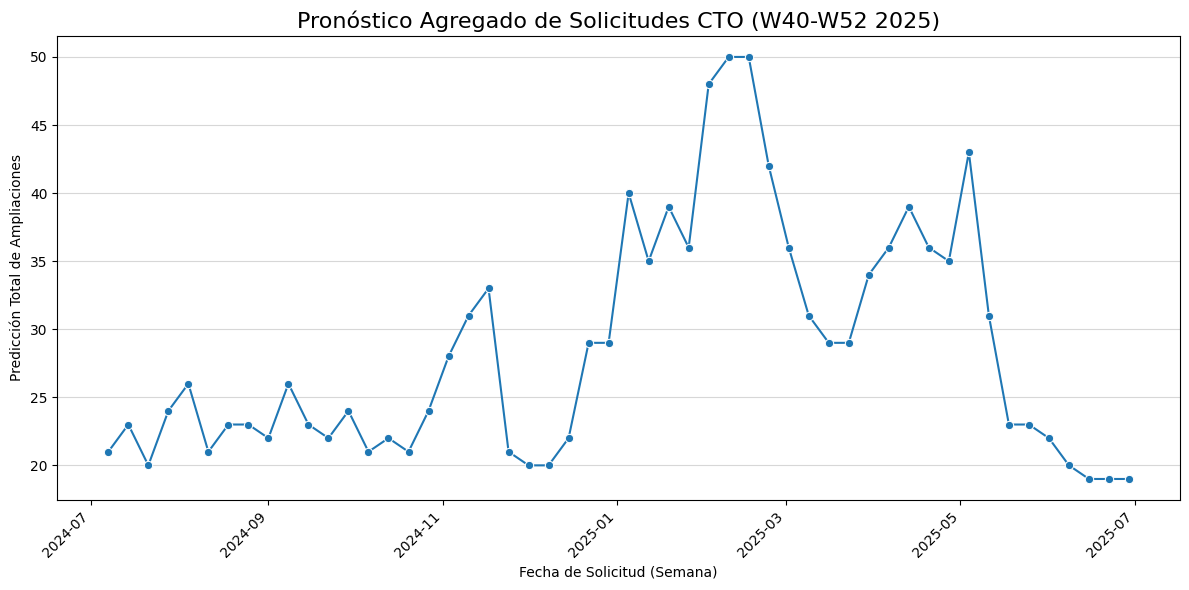

In [ ]:
# 4. Visualización Final
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Agrupamos por semana y sumamos todas las provincias para ver la tendencia total
df_total_semanal = df_output.groupby('Fecha de solicitud')['Número de ampliaciones'].sum().reset_index()
sns.lineplot(data=df_total_semanal, x='Fecha de solicitud', y='Número de ampliaciones', marker='o')

plt.title('Pronóstico Agregado de Solicitudes CTO (W40-W52 2025)', fontsize=16)
plt.xlabel('Fecha de Solicitud (Semana)')
plt.ylabel('Predicción Total de Ampliaciones')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

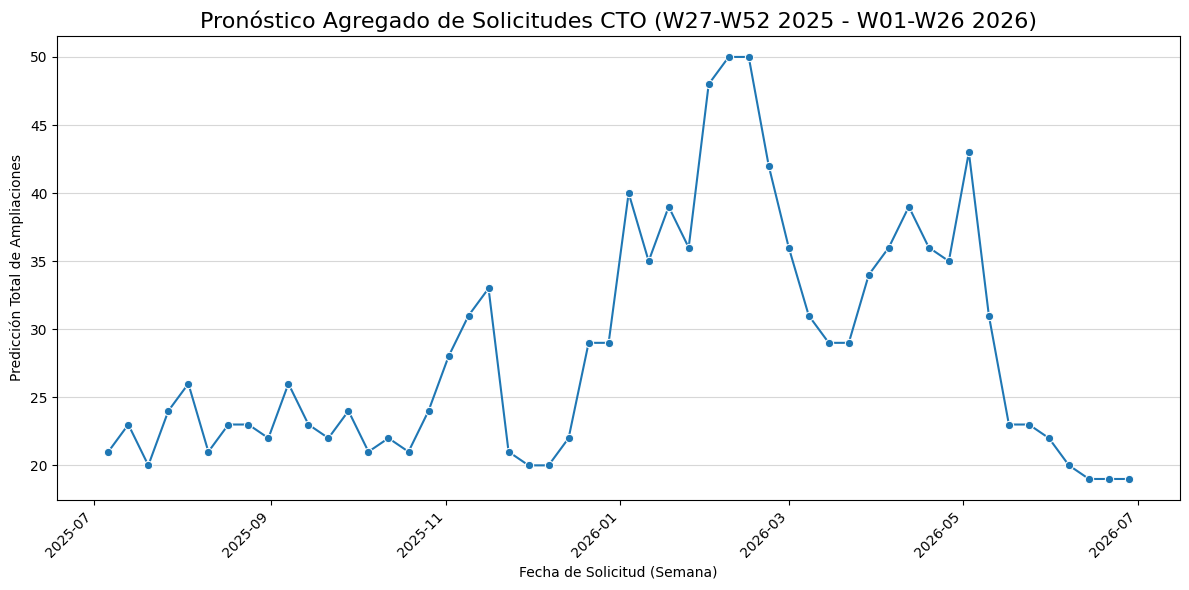

In [40]:
# 4. Visualización Final
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# Agrupamos por semana y sumamos todas las provincias para ver la tendencia total
df_total_pred_semanal = df_pred_output.groupby('Fecha de solicitud')['Número de ampliaciones'].sum().reset_index()
sns.lineplot(data=df_total_pred_semanal, x='Fecha de solicitud', y='Número de ampliaciones', marker='o')

plt.title('Pronóstico Agregado de Solicitudes CTO (W27-W52 2025 - W01-W26 2026)', fontsize=16)
plt.xlabel('Fecha de Solicitud (Semana)')
plt.ylabel('Predicción Total de Ampliaciones')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Guardamos las predicciones
nombre_archivo_total = 'C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_LGB_sin_outliers.csv'
df_total_semanal.to_csv(nombre_archivo_total, index=False, decimal=',', sep=';')



In [43]:
# Guardamos las predicciones
nombre_archivo_total = 'C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_LGBM_pred_final.csv'
df_total_pred_semanal.to_csv(nombre_archivo_total, index=False, decimal=',', sep=';')

#df_pred_output

# Guardamos las predicciones
archivo_con_provincias = 'C:/Users/UX530/Desktop/TFM-GIT/Datasets_Files/ts_LGBM_pred_final_provincias.csv'
df_pred_output.to_csv(archivo_con_provincias, index=False, decimal=',', sep=';')